# MultiLayer Perceptron

In this notebook there are two different MLP architectures, one with 4 hidden layers, batch normalisation, dropout and ReLU activations; and a simpler one with just one hidden layer and a ReLU activation. 

Each of them take as input the MFCCs extrated features from the metadata and give as output the logits to be passed through a Softmax Activation to perform multiclass classification.

## Import packages and allocate device

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isfile
import wandb
from utils import utils
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython import display
import seaborn as sn
from sklearn.metrics import confusion_matrix
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition


In [4]:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0) # make plot background transparent
})

Allocate device

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
print(device)

cpu


## Load data

We'll use the already extracted track features that are stored in the metadata. These come from MFCCs, which are popular features used in audio-related recognition tasks. As seen in ``Data_Exploration``, when we use these in our dataset we see that these are discriminant between different genres.<br><br>
Part the cell below has been collected from [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma) by Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

In [6]:
tracks = utils.load('data/fma_metadata/tracks.csv') # load tracks.csv
features = utils.load('data/fma_metadata/features.csv') # load features.csv

small = tracks['set', 'subset'] <= 'small' # filter small

train = tracks['set', 'split'] == 'training' # filter training
val = tracks['set', 'split'] == 'validation' # filter validation
test = tracks['set', 'split'] == 'test' # filter test

# get genre
y_train = tracks.loc[small & train, ('track', 'genre_top')] 
y_val = tracks.loc[small & val, ('track', 'genre_top')] 
y_test = tracks.loc[small & test, ('track', 'genre_top')]

# get mfcc features
X_train = features.loc[small & train, 'mfcc'] 
X_val = features.loc[small & val, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} validation examples'.format(y_train.size, y_val.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

# Shuffle traininig samples
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)

6400 training examples, 800 validation examples
140 features, 8 classes


array([[-0.15511561, -0.49674298, -0.16143007, ...,  0.91561944,
         0.96924439, -0.54297993],
       [ 0.06436392, -0.45056024,  0.06710116, ..., -0.75143045,
        -0.7469227 , -0.84153531],
       [-0.26499075, -0.40794633,  0.2436578 , ...,  0.02336005,
        -0.45555942, -0.25568189],
       ...,
       [-0.31697505, -0.67543033, -0.4091746 , ..., -0.09201176,
         0.25387012, -0.08211476],
       [-0.28037183, -0.73526121,  2.26467868, ...,  1.08658067,
         0.51588351,  1.88342153],
       [ 0.05569623, -0.59821822, -0.58312677, ..., -0.61566561,
        -0.77430828, -0.66246204]])

In [7]:
X_train = torch.tensor(np.array(X_train))
X_val = torch.tensor(np.array(X_val))
X_test = torch.tensor(np.array(X_test))
print(X_train.shape, X_val.shape)

torch.Size([6400, 140]) torch.Size([800, 140])


We'll map the different genres to numbers, to retrieve them, we'll create dictionary and its reverse version.

In [8]:
# Create a dictionary to map the genres to numbers corresponding to classes
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

# Create a dictionary to map the class numbers to genres
reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [9]:
y_train = torch.tensor(np.array(y_train.map(dict_genres)))
y_val = torch.tensor(np.array(y_val.map(dict_genres)))
y_test = torch.tensor(np.array(y_test.map(dict_genres)))

## Data preparation

Create our dataset <code>MusicDataset</code>. It'll have the number of tracks as length and when called with an index it'll return the information about the track in that position, that is, an array with the MFCCs features and the number corresponding to the genre of the track.

In [10]:
class MusicDataset():
    def __init__(self, x, y):
        self.x = x # spectograms
        self.y = y # genres
        self.n = x.shape[0] # number of audio tracks
        
    def __getitem__(self, index):
        return self.x[index], self.y[index] # return the spectogram and the genre of the audio track

    def __len__(self):
        return self.n # return the number of audio tracks

Create the train, test and validation sets and loaders

In [11]:
batch_size =256 # number of audio files per batch
num_classes = len(dict_genres) # number of genres

train_set = MusicDataset(X_train, y_train)
val_set = MusicDataset(X_val, y_val)
test_set = MusicDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size= batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=False)


To get a better undestranding of the data, print some information about the data we will use for the model.

In [12]:
for batch in train_loader:
    audio_batch, genres = batch

    print(f'We have {audio_batch.shape[0]} tracks in the batch.\n')
    print(f"There are {audio_batch[0].shape[0]} features of the first track of the batch.\n")

    print(f'And this track is from genre {genres[0]}, which is {reverse_map[int(genres[0])]}.')
    break

We have 256 tracks in the batch.

There are 140 features of the first track of the batch.

And this track is from genre 1.0, which is Experimental.


### MLP Model(s)

Implementation of two MLP models: ComplexMLP with 4 hidden layers and SimpleMLP with 1 hidden layer. These models will return logits which will be passed through a ``LogSoftmax`` to perform multi class classification

In [24]:
class ComplexMLP(nn.Module):

    def __init__(self, inDim, num_classes):

        super().__init__()
        
        self.mlp_fw = nn.Sequential(
                nn.Linear(inDim, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(p=0.25),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.BatchNorm1d(512),
                nn.Dropout(p=0.25),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(p=0.25),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.BatchNorm1d(64),
                nn.Dropout(p=0.25),
                nn.ReLU(),
                nn.Linear(64, num_classes),
        )       #these numbers need to be adjusted

    def forward(self, x):
        out = self.mlp_fw(x)
        return out

In [14]:
class SimpleMLP(nn.Module):

    def __init__(self, inDim, num_classes):

        super().__init__()

        self.mlp_fw = nn.Sequential(
                nn.Linear(inDim, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes),
        )       

    def forward(self, x):
        out = self.mlp_fw(x)
        return out

Initialise both models

In [15]:
simple_model = SimpleMLP(inDim = 140, num_classes=8)
print(simple_model)
simple_model = simple_model.to(device, dtype=torch.float64)

SimpleMLP(
  (mlp_fw): Sequential(
    (0): Linear(in_features=140, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [27]:
complex_model = ComplexMLP(inDim = 140, num_classes=8)
print(complex_model)
complex_model = complex_model.to(device, dtype=torch.float64)

ComplexMLP(
  (mlp_fw): Sequential(
    (0): Linear(in_features=140, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.25, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=8, bias=True)
  )
)


## Training and Validation

Set up hyperparameters for both models and perform training and validation. We'll use ``CrossEntropyLoss`` as criterion, as it combines both ``LogSoftmax`` and ``NLLLoss``; and ``Adam`` as optimiser.

In [17]:
learning_rate = 0.0001
lambda_l2 = 1e-4
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

criterion = torch.nn.CrossEntropyLoss()

In [18]:
def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0 #initialize the loss

    model.train() #set the model to training mode

    for batch_idx, (track, target) in enumerate(loader): #for each batch

        optimizer.zero_grad() #zero the gradients

        target = target.long() #squeeze the target and convert it to long
       
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss
        loss.backward() #backpropagate the loss
        optimizer.step() #update the weights
        
         # print loss every N iterations
        if batch_idx % 100 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(track), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))

        total_loss += loss.item()  #.item() is very important here? Why?


    return total_loss / len(loader.dataset)

# Validation function
def validate(criterion, model, loader): 

    val_loss = 0 #initialize the loss
    correct = 0
    preds = []
    model.eval() #set the model to evaluation mode

    for track, target in loader: #for each batch

        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss

        val_loss += loss.item() # sum up batch loss               

        pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset) #calculate the average loss

    # print validation loss and accuracy
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))

    return val_loss, accuracy

#### Simple Model

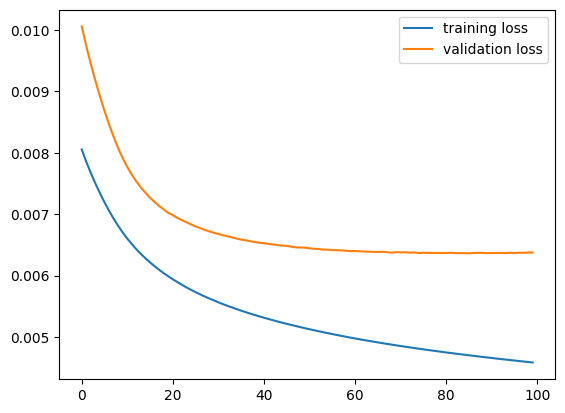

Accuracy: 53.62%


In [19]:
losses = {"train": [], "val": []}

n_epochs = 100

for epoch in range(n_epochs): 

    train_loss = train(epoch, criterion, simple_model, optimizer, train_loader) #train the model
    val_loss, accuracy = validate(criterion, simple_model, val_loader) #validate the model
    losses["train"].append(train_loss) #save the training loss
    losses["val"].append(val_loss) #save the validation loss
    
    display.clear_output(wait=True) 

    plt.plot(losses["train"], label="training loss") #plot the training loss
    plt.plot(losses["val"], label="validation loss") #plot the validation loss

    plt.legend()
    plt.pause(0.000001)
    plt.show()

print(f'Accuracy: {accuracy:.2f}%') 

Testing and Confusion Matrix

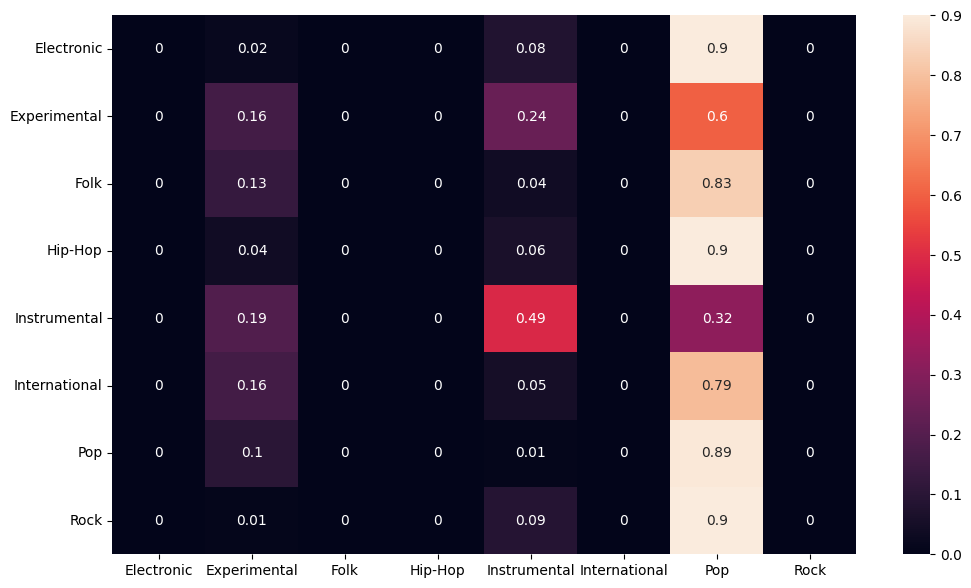

In [20]:
y_pred = []
for track, target in test_loader: #for each batch
        m = nn.LogSoftmax(dim=1)
        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = m(simple_model(track)) #get the output of the model      
        pred = output.data.max(1, keepdim=True)[1]
        y_pred.append(pred)

y_pred = torch.cat(y_pred)
y_pred = y_pred.view(-1)

c_m = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(c_m / np.sum(c_m, axis=1)[:, None], index = [i for i in dict_genres.keys()], columns = [i for i in dict_genres.keys()])

plt.figure(figsize = (12,7))
plt.title('')
sn.heatmap(df_cm, annot=True)

plt.show()

#### Complex Model

In [28]:
learning_rate = 0.00005
lambda_l2 = 1e-4
optimizer = torch.optim.Adam(complex_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
criterion = torch.nn.CrossEntropyLoss()

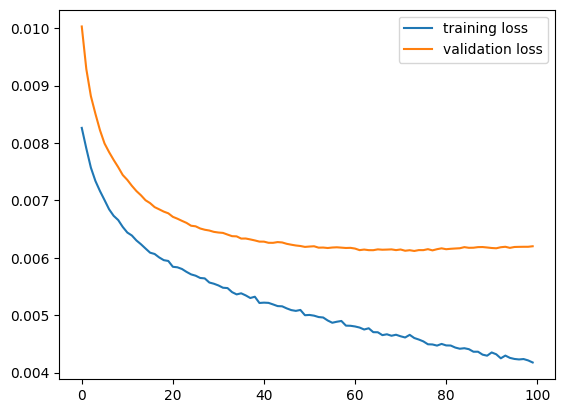

Accuracy: 55.38%


In [29]:
losses = {"train": [], "val": []}
n_epochs = 100
for epoch in range(n_epochs): 

    train_loss = train(epoch, criterion, complex_model, optimizer, train_loader) #train the model
    val_loss, accuracy = validate(criterion, complex_model, val_loader) #validate the model
    losses["train"].append(train_loss) #save the training loss
    losses["val"].append(val_loss) #save the validation loss
    
    display.clear_output(wait=True) 

    plt.plot(losses["train"], label="training loss") #plot the training loss
    plt.plot(losses["val"], label="validation loss") #plot the validation loss

    plt.legend()
    plt.pause(0.000001)
    plt.show()

print(f'Accuracy: {accuracy:.2f}%') 

Testing and Confusion Matrix

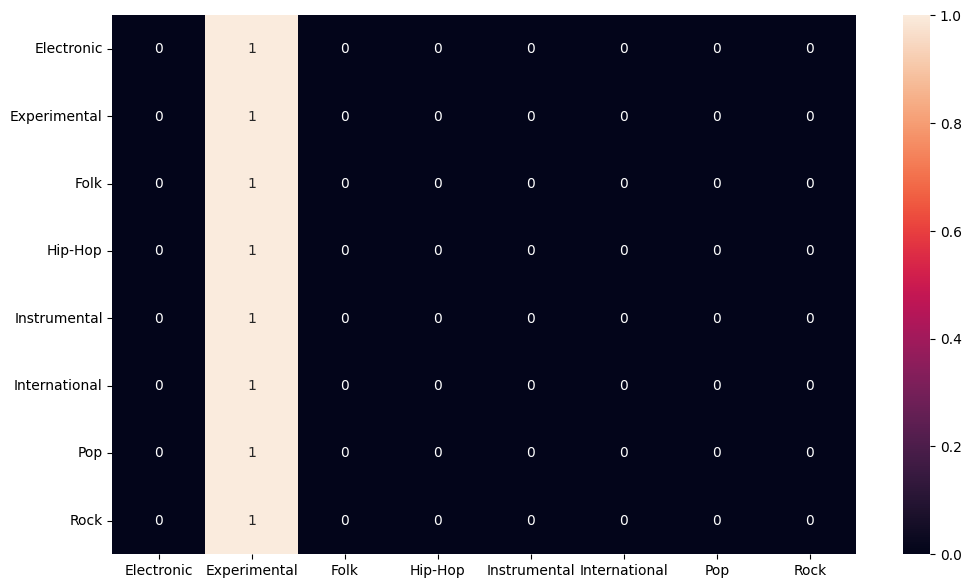

In [30]:
y_pred = []
for track, target in test_loader: #for each batch
        m = nn.LogSoftmax(dim=1)
        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = m(complex_model(track)) #get the output of the model      
        pred = output.data.max(1, keepdim=True)[1]
        y_pred.append(pred)

y_pred = torch.cat(y_pred)
y_pred = y_pred.view(-1)

c_m = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(c_m / np.sum(c_m, axis=1)[:, None], index = [i for i in dict_genres.keys()], columns = [i for i in dict_genres.keys()])

plt.figure(figsize = (12,7))
plt.title('')
sn.heatmap(df_cm, annot=True)

plt.show()

## Conclusion

As seen in the plots and results above, despite being slightly better than random guess, neither of them performs well on this task, with an accuracy around 52-55% percent in both models, being the complex model the one with highest accuracy among them.

Based on that the training curves seemed to be improving while the validation curve was static or increasing in some cases after a certain number of epochs, our conclusions are that the models overfit, learning the training set, which translates in poor validation performance. 

From different available solutions to overfitting, we could simplify the model, which we have done with SimpleMLP, or obtain or generate more data.

However, when taking a look at the confusions matrix we can observe that the Simple Model has learned to only differentiate between Instrumental, Experimental, Pop and in few cases, Folk; it only performs well on the singular case of pop songs. (this can vary depending on the run).

On the other hand, the Complex Model, which by looking only at accuracy seemed to perform slightly better than the Simple one, shows that it only has learned to classify all tasks as Experimental, which reinforces the believe that using a simpler model for this task with this given data is a better approach.